In [51]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel

%matplotlib inline

In [10]:
dataset_path = 'reddit_wsb.csv'
data = pd.read_csv(dataset_path)

data

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...,...
48255,It's time I let you in on my secret: balls dee...,16,nhsv8s,https://www.reddit.com/r/wallstreetbets/commen...,19,1.621633e+09,Canadian Solar $CSIQ\n\n**Legitimate company a...,2021-05-22 00:44:00
48256,Guaranteed Buyout and Doubling of Funds if gra...,0,nhssad,https://www.reddit.com/r/wallstreetbets/commen...,11,1.621633e+09,&#x200B;\n\nThe only thing certain in life is ...,2021-05-22 00:40:14
48257,Which month the market crashed the most? October.,24,nhruo1,https://www.reddit.com/r/wallstreetbets/commen...,19,1.621631e+09,I was just wondering: In which month the stock...,2021-05-21 23:56:24
48258,🕵️‍♂️ I SPY 5/21 Read 🔭🎯,133,nhrou0,https://www.reddit.com/r/wallstreetbets/commen...,74,1.621630e+09,# SPY - BULLISH - NEUTRAL\n\nGamma Index: Incr...,2021-05-21 23:48:06


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      48260 non-null  object 
 1   score      48260 non-null  int64  
 2   id         48260 non-null  object 
 3   url        48260 non-null  object 
 4   comms_num  48260 non-null  int64  
 5   created    48260 non-null  float64
 6   body       22521 non-null  object 
 7   timestamp  48260 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.9+ MB


In [12]:
data.dropna(subset=['body'], inplace=True)

In [13]:
data['original_body'] = data['body']

In [14]:
data.head()

,title,score,id,url,comms_num,created,body,timestamp,original_body
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,The CEO of NASDAQ pushed to halt trading “to g...
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,Hedgefund whales are spreading disinfo saying ...
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31,Life isn't fair. My mother always told me that...
10,"We need to keep this movement going, we all ca...",222,l6uao1,https://www.reddit.com/r/wallstreetbets/commen...,70,1.611862e+09,I believe right now is one of those rare oppo...,2021-01-28 21:18:25,I believe right now is one of those rare oppo...
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1.611861e+09,You guys are champs. GME... who would have tho...,2021-01-28 21:17:10,You guys are champs. GME... who would have tho...


In [15]:
data.shape

(22521, 9)

In [16]:
nlp = spacy.blank('en')

In [17]:

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [18]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
def remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [20]:
def lemmatize_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [21]:
remove_spaces = lambda x : re.sub('\\s+', ' ', x)

In [22]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [23]:
remove_double_quotes = lambda x : x.replace('"', '')
remove_single_quotes = lambda x : x.replace('\'', '')
trim = lambda x : x.strip()

In [24]:
other_chars = ['*', '#', '&x200B', '[', ']', '; ',' ;' "&nbsp", "“","“","”", "x200b"]
def remove_other_chars(x: str):
    for char in other_chars:
        x = x.replace(char, '')
    
    return x

In [25]:
def lower_case_text(text):
    return text.lower()

In [26]:
funcs = [
    remove_urls, 
    remove_punctuation,
    remove_stop_words, 
    remove_emoji, 
    remove_double_quotes, 
    remove_single_quotes,
    lower_case_text,
    remove_other_chars,
    lemmatize_words,
    remove_spaces,
    trim]

for fun in funcs:
    data['body'] = data['body'].apply(fun)

In [27]:
# reset indexes (again)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

data

,title,score,id,url,comms_num,created,body,timestamp,original_body
0,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,ceo nasdaq pushed halt trading investors chanc...,2021-01-28 21:30:35,The CEO of NASDAQ pushed to halt trading “to g...
1,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,hedgefund whales spreading disinfo saying frid...,2021-01-28 21:26:27,Hedgefund whales are spreading disinfo saying ...
2,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,life nt fair mother told complain arbitrary tr...,2021-01-28 21:19:31,Life isn't fair. My mother always told me that...
3,"We need to keep this movement going, we all ca...",222,l6uao1,https://www.reddit.com/r/wallstreetbets/commen...,70,1.611862e+09,believe right rare opportunities help good com...,2021-01-28 21:18:25,I believe right now is one of those rare oppo...
4,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1.611861e+09,guys champs gme thought bunch crazy retards re...,2021-01-28 21:17:10,You guys are champs. GME... who would have tho...
...,...,...,...,...,...,...,...,...,...
22516,It's time I let you in on my secret: balls dee...,16,nhsv8s,https://www.reddit.com/r/wallstreetbets/commen...,19,1.621633e+09,canadian solar csiq legitimate company meme ye...,2021-05-22 00:44:00,Canadian Solar $CSIQ\n\n**Legitimate company a...
22517,Guaranteed Buyout and Doubling of Funds if gra...,0,nhssad,https://www.reddit.com/r/wallstreetbets/commen...,11,1.621633e+09,thing certain life death taxes – add list fact...,2021-05-22 00:40:14,&#x200B;\n\nThe only thing certain in life is ...
22518,Which month the market crashed the most? October.,24,nhruo1,https://www.reddit.com/r/wallstreetbets/commen...,19,1.621631e+09,wondering month stock market case dow jones cr...,2021-05-21 23:56:24,I was just wondering: In which month the stock...
22519,🕵️‍♂️ I SPY 5/21 Read 🔭🎯,133,nhrou0,https://www.reddit.com/r/wallstreetbets/commen...,74,1.621630e+09,spy bullish neutral gamma index increased 004 ...,2021-05-21 23:48:06,# SPY - BULLISH - NEUTRAL\n\nGamma Index: Incr...


In [28]:
''.join(char for char in data.body.loc[4] if char in string.printable)

'guys champs gme thought bunch crazy retards reach page new york times gme time punish big banks suppressing price silver bear stearns jpm merge fucking bloomberg s excellent explanation scheme think gme squeezed hard look happened silver half year ago july s banks getting squeezed silver having cover shorts s rich boomers freaked financial instability finally started calling comex bullshit taking physically delivery silver nt imagine 4 million degenerates buying slv forcing trust delivery physical silver comex nt gme s fair price maybe 5 share fair price silver based historical goldsilver ratio surely 50ounce short squeeze fantastic success silver fair market value s ag silver starts moving ag going fucking moon 1 leverage play silver 2 got shorts squeezed 23 short float count tldr thing gets going shares calls slv ag rocket edit'

In [29]:
body_list = data.body.tolist()

In [30]:
body_list[0]

'ceo nasdaq pushed halt trading investors chance recalibrate positions sec investigating brokers disallowing buying calls institutions flat admitting change rules bail rich happens shucks known investing risky tried cutting avocados coffee maybe uber collectively driven sentiment wall street big players long gme money stock hurt wall street funds went went profited shorts media wants pin blame crystal clear rigged game time build new exchanges arbitrarily change rules cro version maybe repurposed trade stock government intervention know exactly look like broad steps 1 exit current financial system 2 build new'

### Most frequent ngrams
##### Now that most of the meaningless words have been removed, let's see which are the most frequent unigrams.

In [32]:
counter = Counter()

for body in body_list:
    doc = nlp(body)
    counter.update([token.text for token in doc])

In [33]:
most_common_unigrams = counter.most_common()[0:30]
words = [item[0] for item in most_common_unigrams]
freq = [item[1] for item in most_common_unigrams]

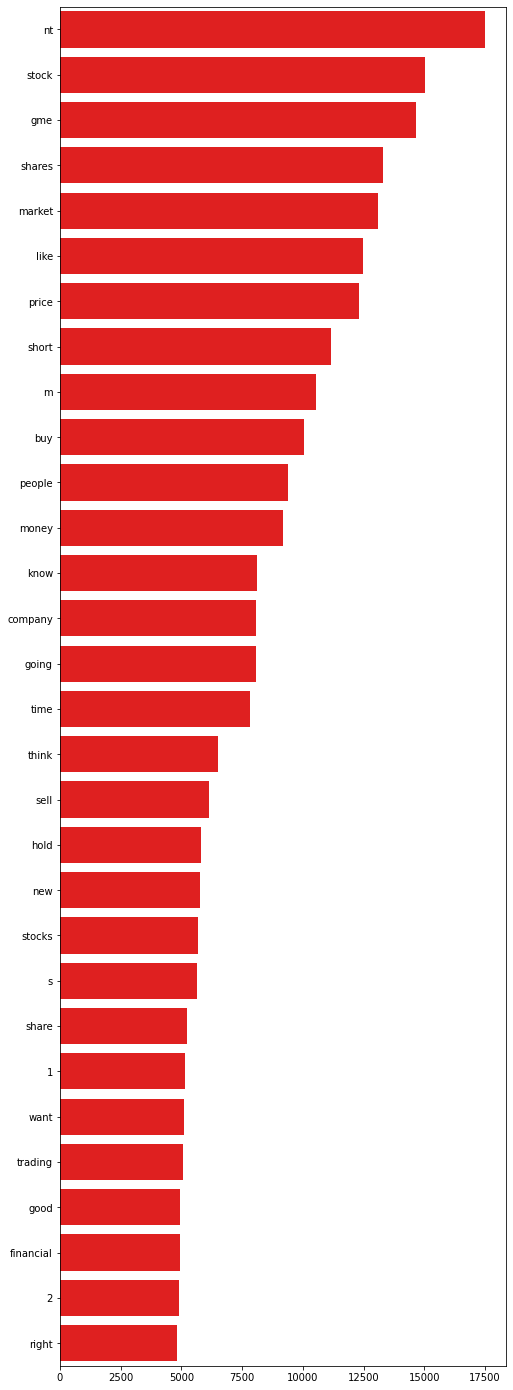

In [34]:
plt.figure(figsize=(8, 25))
sns.barplot(y=words, x=freq, color='red')

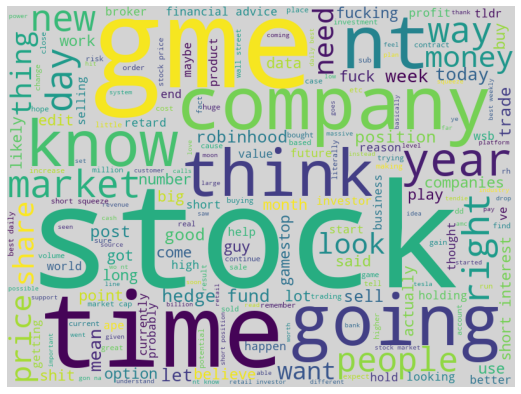

In [36]:
fig_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightgrey', 
                          colormap='viridis', width=800, height=600
                         ).generate(' '.join(body_list))

plt.figure(figsize=(10, 7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.show()

In [37]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [38]:
bigram_counter = Counter()

for body in body_list:
    bigram_counter.update(generate_ngrams(body, 2))

In [39]:
most_common_bigrams = bigram_counter.most_common()[0:30]
bigrams = [item[0] for item in most_common_bigrams]
bi_freq = [item[1] for item in most_common_bigrams]

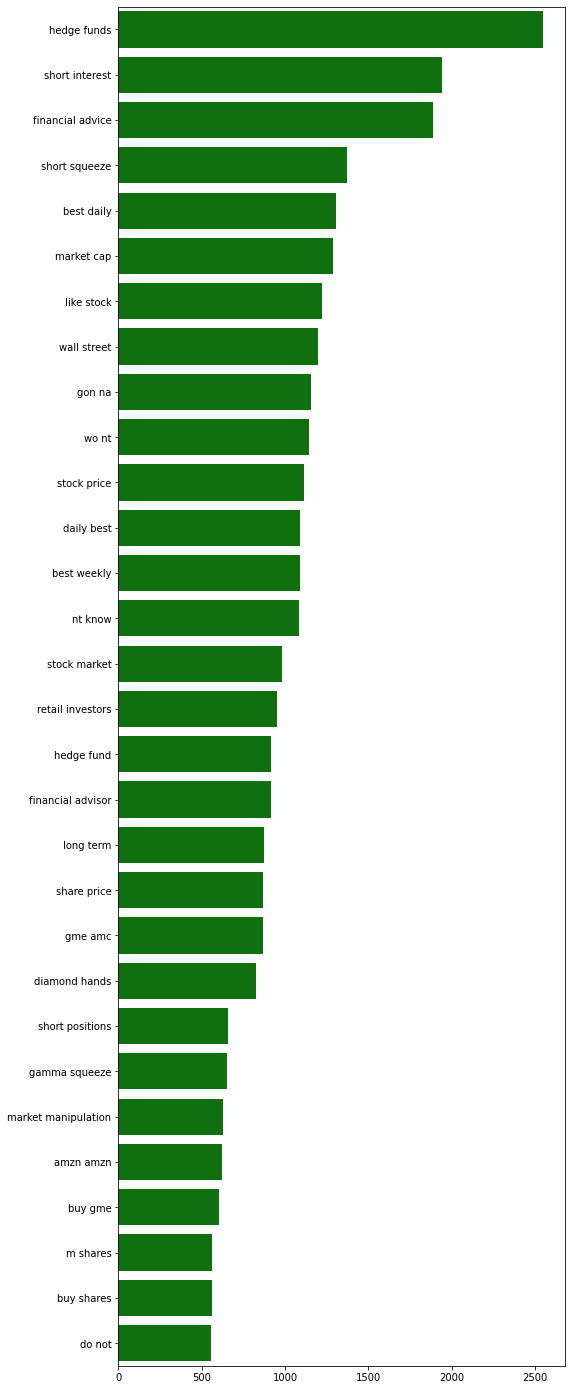

In [40]:
plt.figure(figsize=(8, 25))
sns.barplot(y=bigrams, x=bi_freq, color='green')

In [41]:
trigram_counter = Counter()

for body in body_list:
    trigram_counter.update(generate_ngrams(body, 3))

In [42]:
most_common_trigrams = trigram_counter.most_common()[0:30]
trigrams = [item[0] for item in most_common_trigrams]
tri_freq = [item[1] for item in most_common_trigrams]

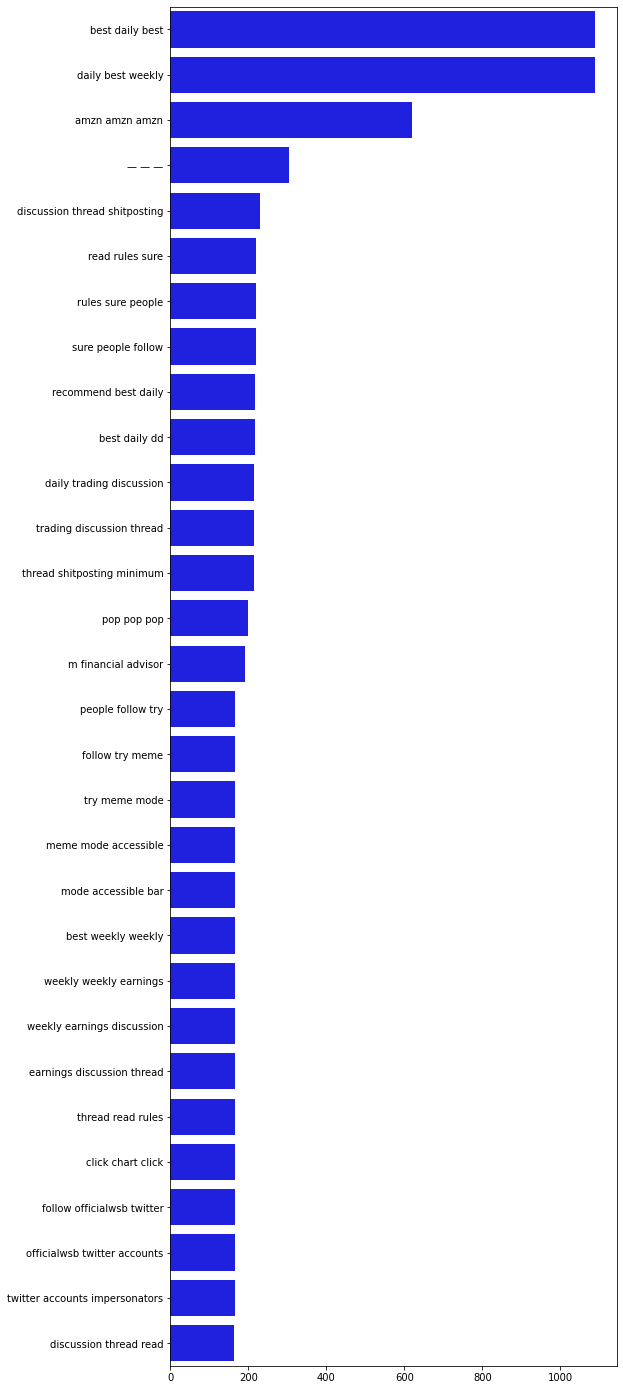

In [43]:
plt.figure(figsize=(8, 25))
sns.barplot(y=trigrams, x=tri_freq, color='blue')

## Topic Modeling Using LDA

In [44]:
docs = [body.split() for body in body_list]

In [47]:
dic = Dictionary(docs)

In [49]:
print(dic)

Dictionary(78284 unique tokens: ['1', '2', 'admitting', 'arbitrarily', 'avocados']...)


In [50]:
corpus = [dic.doc2bow(doc) for doc in docs]

In [53]:
number_of_topics = 10

## Training
##### Now it's time to train our topic model. We do this with the following parameters:

##### corpus: the bag-of-word representations of our documents
##### id2token: the mapping from indices to words
##### num_topics: the number of topics we want the model to identify
##### chunksize: the number of documents the model sees for every update
##### passes: the number of times we show the total corpus to the model during training
##### random_state: we use a seed to ensure reproducibility.

In [54]:
model = LdaModel(corpus=corpus, id2word=dic, num_topics=number_of_topics, chunksize=2500, passes=5, random_state=1)

In [55]:
for (topic, words) in model.print_topics():
    print(topic+1, ":", words, '\n\n')

1 : 0.016*"nt" + 0.011*"like" + 0.011*"going" + 0.010*"money" + 0.009*"people" + 0.008*"know" + 0.008*"stock" + 0.007*"think" + 0.007*"time" + 0.007*"s" 


2 : 0.022*"approved" + 0.022*"fda" + 0.019*"q1" + 0.017*"pharma" + 0.012*"q3" + 0.009*"patent" + 0.009*"advertising" + 0.008*"product" + 0.007*"june" + 0.007*"results" 


3 : 0.011*"market" + 0.007*"rates" + 0.006*"demand" + 0.005*"time" + 0.005*"settings" + 0.005*"price" + 0.004*"spy" + 0.004*"value" + 0.004*"ma" + 0.004*"marijuana" 


4 : 0.035*"–" + 0.023*"cancer" + 0.013*"prostate" + 0.013*"fibroids" + 0.010*"gold" + 0.010*"drugs" + 0.010*"billion" + 0.009*"endometriosis" + 0.008*"solar" + 0.008*"going" 


5 : 0.029*"nt" + 0.022*"buy" + 0.020*"gme" + 0.017*"fucking" + 0.017*"m" + 0.017*"fuck" + 0.013*"hold" + 0.012*"like" + 0.011*"know" + 0.011*"sell" 


6 : 0.042*"japanese" + 0.016*"bla" + 0.012*"smma" + 0.010*"antagonist" + 0.010*"triggering" + 0.010*"commercialize" + 0.010*"dnmr" + 0.010*"offering" + 0.010*"pregnancy" + 0.010

In [56]:
original_body_list = data.original_body.tolist()

In [58]:
for (text, doc) in zip(original_body_list[:9], docs[:9]):
    print('\033[1m' + 'Text: ' + '\033[0m', text)
    print('\033[1m' + 'Topics: ' + '\033[0m', [(topic+1, prob) 
for (topic, prob) in model[dic.doc2bow(doc)] if prob > 0.15])
    print('\n')

Text:  The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. The media wants to pin the blame on us.

It should be crystal clear that this is a rigged game by now. Its time t

In [59]:
for (text, doc) in zip(original_body_list[:9], docs[:9]):
    print('\033[1m' + 'Text: ' + '\033[0m', text)
    print('\033[1m' + 'Topics: ' + '\033[0m', [(topic+1, prob) 
for (topic, prob) in model[dic.doc2bow(doc)] if prob > 0.15])
    print('\n')

Text:  The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. The media wants to pin the blame on us.

It should be crystal clear that this is a rigged game by now. Its time t

## Conclusion
##### Finding patterns and understanding the hidden structure of data is a complicated task. Especially when we are dealing with messy and unstructured data as text. Topic models such as Latent Dirichlet Allocation or matrices decomposition are useful techniques to discover the most prominent topics in such documents. While these results are often very revealing already, it's also possible to use them as a starting point, for example for a labeling exercise for supervised text classification. Although traditional topic models are lacking in more semantic information (they don't use word embeddings, for instance), they should be in every NLPer's toolkit as a really quick way of getting insights into large collections of documents.